# Classification accuracy metrics for pixel based and object based classification

The schema for this analysis was adopted from the description of object-based statistics in
Caicedo et al. (2018) Evaluation of Deep Learning Strategies for Nucleus Segmentation
in Fluorescence Images. BioRxiv 335216.

The SEG metric was adapted from Maška et al. (2014). A benchmark for comparison of cell
tracking algorithms. Bioinformatics 30, 1609–1617.

The linear classification schema used to match objects in truth and prediction frames was
adapted from Jaqaman et al. (2008). Robust single-particle tracking in live-cell
time-lapse sequences. Nature Methods 5, 695–702.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from skimage.io import imshow

from skimage.measure import label

import deepcell.datasets
from deepcell import metrics

Using TensorFlow backend.


# Load data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

6370107392/6370099814 [==============================] - 162s 0us/step
X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


# Instantiate model from saved weights

First instantiate a model from the deepcell `model_zoo`.

In [3]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=61,
    n_skips=3,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

Compile the model and load weights from a previously trained model.

In [4]:
from tensorflow.keras.optimizers import SGD

fgbg_model.compile(SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
fgbg_model.load_weights('/models/conv_fgbg_model.h5')

# Generate predictions from test data

In [5]:
predict = fgbg_model.predict(X_test)[-1]

Use `skimage.measure.label` to identify discrete objects (nuclei) in the prediction data.

In [6]:
predict_lbl = label((predict[:,:,:,1]>0.5).astype('int'))

Visualize the image at each stage in processing.

1085
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

True positives:  10	Accuracy:   76.92%

False positives: 0	Perc Error: 0.0%
False negatives: 10	Perc Error: 50.0%
Merges:		 1	Perc Error: 50.0%
Splits:		 0	Perc Error: 0.0%

SEG: 0.8597


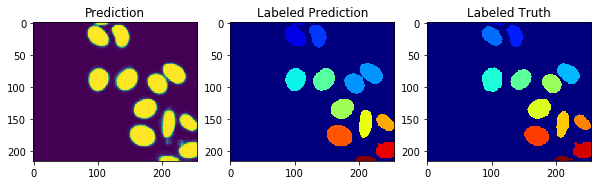

In [45]:
# Select a random sample to view
i = np.random.randint(0,high=1440)
print(i)

y_true = label(y_test[i:i+1,:,:,0].astype('int'))
y_pred = label(predict_lbl[i:i+1])

fig,ax = plt.subplots(1,3,figsize=(10,8))
ax[0].imshow(predict[i,:,:,1])
ax[0].set_title('Prediction')
# Repeat labeling to get number assignments in range for this particular frame
ax[1].imshow(y_pred[0],cmap='jet')
ax[1].set_title('Labeled Prediction')
ax[2].imshow(y_true[0],cmap='jet')
ax[2].set_title('Labeled Truth')

m = metrics.Metrics('singleton',seg=True)
m.calc_object_stats(y_true,y_pred)

# Run metrics on complete test set

In [47]:
reload(metrics)

<module 'deepcell.metrics' from '/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py'>

In [48]:
%%time
m = metrics.Metrics('fgbg',seg=True)

y_true_lbl = y_test[:,:,:,0].astype('int')
y_pred_lbl = predict_lbl

m.calc_object_stats(y_true_lbl,y_pred_lbl)

INFO:tensorflow:0 samples processed


/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:595: RuntimeWarning: Mean of empty slice
  self.seg_score = np.nanmean(iou_mask[self.true_pos_ind[0], self.true_pos_ind[1]])


INFO:tensorflow:200 samples processed
INFO:tensorflow:400 samples processed
INFO:tensorflow:600 samples processed
INFO:tensorflow:800 samples processed
INFO:tensorflow:1000 samples processed
INFO:tensorflow:1200 samples processed
INFO:tensorflow:1400 samples processed

____________Object-based statistics____________

Number of true cells:		 10338
Number of predicted cells:	 9917

True positives:  8396	Accuracy:   81.21000000000001%

False positives: 582	Perc Error: 35.75%
False negatives: 8396	Perc Error: 22.36%
Merges:		 681	Perc Error: 41.83%
Splits:		 1	Perc Error: 0.06%

SEG: 0.8439 

CPU times: user 1min 3s, sys: 216 ms, total: 1min 3s
Wall time: 1min 3s


Note: pixel based statistics are also available from `m.all_pixel_stats`, but it requires that the ground truth annotation be transformed to match the features output by the model prediction.

Additionally, the final metric report can be saved using `m.save_to_json(m.output)` after object and/or pixel statistics have been generated.

Currently this dataset has small enough frame sizes that they can be looped over in `m.calc_object_stats` without too much of a problem. For datasets with larger frame sizes, the function `metrics.split_stack` can be used to reshape the data into a managable size.